In [1]:
%%time
from tqdm import tqdm
import numpy as np
from itertools import combinations
import torch
import math
import matplotlib.pyplot as plt
from matplotlib import colors


Wall time: 3.46 s


In [2]:
import math
from copy import deepcopy
# Formula for N choose K
def nCk(n,k):
    f = math.factorial
    return f(n)//f(k)//f(n-k)

#Formula to find the positions of the set bits
def find_set_bits(number):
    bits = []
    for i, c in enumerate(bin(number)[:1:-1]):
        if c == '1':
            bits.append(i)
    return bits

In [3]:
#Function to obtain all valid configurations for a constraint
def create_possibilities(no_empty, groups, color_sequence):
    all_valid_configs=[]
    #Obtain all valid permutations of the groups
    for p in combinations(range(groups+no_empty), groups):
        valid_config = []
        #Initialize the whole list of length groups+no_empty with 0
        selected = [0]*(groups+no_empty)
        #indicate the valid positions where the groups can go
        ones_idx = 1
        for val in p:
            selected[val] = ones_idx
            ones_idx += 1

        #Add the ones to the selected places where groups can go
        for val in selected:
            if val>0:
                valid_config.extend(color_sequence[val-1])
            else:
                valid_config.extend([0])

        all_valid_configs.append(valid_config)
    return all_valid_configs
    


In [4]:
state = 0 # 0: size, 1: row hints, 2: col hints
row_hints = []
col_hints = []

row_colors = []
col_colors = []


"""Read constraints"""
with open("colored_nonograms/constraints1.txt") as f:
    for line in f:
        line_lst = line.split()
        if len(line_lst) == 0:
            state += 1
            continue
            
        if state == 0:
            num_rows, num_cols = tuple(map(int, line_lst))
            
        if state == 1:
            row_hints.append(list(map(int, line_lst)))
            
        if state == 2:
            col_hints.append(list(map(int, line_lst)))


"""Read color mappings"""
with open("colored_nonograms/colors1.txt") as f:
    #Read all color mappings
    colors_file = []
    numbers = []
    color_names = []
    for line in f:
        line_lst = line.split()
        if len(line_lst) == 0:
            state = 1
            break
        colors_file.append(line_lst[0])
        numbers.append(int(line_lst[1]))
        color_names.append(line_lst[2])

    #Read the colors of the constraints 
    for line in f:
        line_lst = line.split()
        if len(line_lst) == 0:
            state += 1
            continue

        if state == 1:
            row_colors.append(list(map(int, line_lst)))
            
        if state == 2:
            col_colors.append(list(map(int, line_lst)))

color_names.insert(0, 'white')

In [5]:
row_configs = []
col_configs = []

"""Build Valid configurations for row constraints"""
for (constraint, color) in zip(row_hints, row_colors):
    #Color sequence corresponding to how many times the color appears
    color_sequence = [list([color_num]*x) for (x, color_num) in zip(constraint, color)]

    #Add a zero to the end of the color_sequence if there are 2 consecutive colors
    #keep track of how many zeros there are in between
    in_between_zeros = 0
    for idx in range(len(color)-1):
        if color[idx] == color[idx + 1]:
            color_sequence[idx].extend([0])
            in_between_zeros +=1

    #Obtain number of empty cells that can be freely moved around the row
    groups = len(constraint)
    no_empty = num_cols - (sum(constraint) + in_between_zeros)
    num_of_configs = nCk(groups+no_empty, no_empty)

    res = create_possibilities(no_empty, groups, color_sequence)
    row_configs.append(res)

"""Build Valid configurations for column constraints"""
for (constraint, color) in zip(col_hints, col_colors):
    #Color sequence corresponding to how many times the color appears
    color_sequence = [list([color_num]*x) for (x, color_num) in zip(constraint, color)]

    #Add a zero to the end of the color_sequence if there are 2 consecutive colors
    #keep track of how many zeros there are in between
    in_between_zeros = 0
    for idx in range(len(color)-1):
        if color[idx] == color[idx + 1]:
            color_sequence[idx].extend([0])
            in_between_zeros +=1

    #Obtain number of empty cells that can be freely moved around the row
    groups = len(constraint)
    no_empty = num_rows - (sum(constraint) + in_between_zeros)

    res = create_possibilities(no_empty, groups, color_sequence)
    col_configs.append(res)


In [6]:
#Raise to the power of 2 the valid configurations
for n in range(len(row_configs)):
    row_configs[n] = torch.pow(2, torch.tensor(row_configs[n], dtype = torch.int))

for n in range(len(col_configs)):
    col_configs[n] = torch.pow(2, torch.tensor(col_configs[n], dtype = torch.int))


In [7]:
#Initialize all messages to the binary value with all ones, 
# whose number of ones = num_colors + 1 (for the non-colored case)
all_ones = torch.tensor(0b1, dtype=torch.int)
for i in range(len(colors_file)):
    all_ones = torch.bitwise_or(all_ones<<1, 0b1)


messages_rows_down = all_ones*torch.ones(num_rows, num_cols, dtype=torch.int)
messages_columns_down = all_ones*torch.ones(num_rows, num_cols,dtype=torch.int)
messages_up = all_ones*torch.ones(num_rows, num_cols,dtype=torch.int)

In [8]:
import textwrap

def plot_solved_nonogram(iteration, messages_up, ambiguous_cells):
    cmap = colors.ListedColormap(['#FFFFFF']+ [colors_from_file for colors_from_file in colors_file] + ['#B7B7B7'])
    #bounds = [0, 1.1, 2.1, 4.1, 8.1, 16.1, 32.1, 64.1, 128.1, 256.1, 512.1, 1024.1]
    bounds = [0]+[ + 2**val + 0.1 for val in range(len(colors_file) + 1)]+[2**(len(colors_file))+100]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    messages_for_plotting = messages_up*ambiguous_cells
    messages_for_plotting[messages_for_plotting==0] = 2**len(colors_file)+10
    

    fig, ax = plt.subplots()
    fig.set_figheight(30)
    fig.set_figwidth(30)

    ax.imshow(messages_for_plotting, cmap=cmap, norm=norm)
    ax.set_title(f'Iteration {iteration}', fontsize = 40)
    #ax.set_title(f'Solution {iteration}', fontsize = 40)
    for (j,i),message in np.ndenumerate(messages_up):
        j = j-0.3
        i = i-0.3
        colors_possible_number = find_set_bits(message)
        text_possible_colors = [color_names[i] for i in colors_possible_number]
        for text in text_possible_colors:
            box = ax.text(i,j,text,ha='left',va='top', bbox=dict(alpha=0, boxstyle='square, pad=0'))
            j = j + 0.2

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, num_cols+0.5, 1));
    ax.set_yticks(np.arange(-0.5, num_rows+0.5, 1));
    fig.savefig(f'final_picture_iter_{iteration}.png')
    #fig.savefig(f'multiple_sol_final_{iteration}.png')




In [9]:
#Main function
all_solutions = []
num_of_recursion = 0
def updated_nonogram_solver(messages_up, messages_rows_down, messages_columns_down, row_configs, col_configs):
    guess_made = False
    for iteration in range(100):
        """Updating messages going up from the messages going towards the row factors"""
        for row in range(num_rows):
            if(iteration != 0):
                #Remove configurations based on previous messages
                filtered_rows = torch.bitwise_and(row_configs[row], messages_up[row,:]).all(dim=1)
                row_configs[row] = row_configs[row][filtered_rows]
            for col in range(num_cols):
                mask = messages_up[row, :].clone()
                for i in range(len(colors_file) + 1):
                    if(torch.bitwise_and(messages_rows_down[row, col], 0b1<<i) != 0):
                        mask[col] = torch.tensor(0b1<<i, dtype = torch.int)
                        masked_result = torch.bitwise_and(row_configs[row], mask).all(dim=1).any()
                        #If the result is false, then set that message to zero
                        if(masked_result == False): 
                            mask_for_msg = torch.bitwise_and(all_ones, ~(0b1<<i))
                            messages_rows_down[row, col] = torch.bitwise_and(messages_rows_down[row, col], mask_for_msg)

        """Update messages going up from the messages going towards the column factors"""
        for col in range(num_cols):
            if(iteration != 0):
                #Remove configurations based on previous messages
                filtered_cols = torch.bitwise_and(col_configs[col], messages_up[:,col]).all(dim=1)
                col_configs[col] = col_configs[col][filtered_cols]
            for row in range(num_rows):
                mask = messages_up[:, col].clone()
                for i in range(len(colors_file) + 1):
                    if(torch.bitwise_and(messages_columns_down[row, col], 0b1<<i) != 0):
                        mask[row] = torch.tensor(0b1<<i, dtype = torch.int)
                        masked_result = torch.bitwise_and(col_configs[col], mask).all(dim=1).any()
                        if(masked_result == False):
                            mask_for_msg = torch.bitwise_and(all_ones, ~torch.tensor(0b1<<i, dtype = torch.int))
                            messages_columns_down[row, col] = torch.bitwise_and(messages_columns_down[row, col], mask_for_msg)
                            
        """Update messages leaving the equality constraints towards all edges X_{i,j}"""
        messages_up_new = torch.bitwise_and(messages_columns_down, messages_rows_down)

        """Check if algorithm has stalled and make guesses"""
        if (messages_up==messages_up_new).all():
            #Get the index of the first message that hasn't changed
            ambiguous_messages = torch.log2(messages_up_new) % 1 != 0
            index_msg_not_changed = (ambiguous_messages == True).nonzero(as_tuple=False)[0]
            #set the message corresponding to that cell equal to one of the possible colors it can take and 0 for others
            set_bits = find_set_bits(messages_up_new[index_msg_not_changed[0], index_msg_not_changed[1]])
            #Make all possible guesses
            for i in set_bits:
                guess_made = True
                print("guess made")
                print(index_msg_not_changed)
                messages_up_new[index_msg_not_changed[0], index_msg_not_changed[1]] = 0b1<<i
                messages_rows_down_new = deepcopy(messages_up_new)
                messages_columns_down_new = deepcopy(messages_up_new)
                row_configs_new = deepcopy(row_configs)
                col_configs_new = deepcopy(col_configs)
                solved, message_up_valid = updated_nonogram_solver(messages_up_new, messages_rows_down_new, messages_columns_down_new, row_configs_new, col_configs_new)
        
        #Stopping to avoid re-running the same case as the last one
        if (guess_made == True):
            return solved, message_up_valid

        """If messages have changed, continue as usual"""
        messages_up = deepcopy(messages_up_new)

        """Obtain a matrix with True values in the positions where the messages are not yet decided, False anywhere else. For plotting purposes only"""
        ambiguous_cells = torch.log2(messages_up) % 1 == 0

        """Save the nonogram with the updated messages from the current iteration"""
        plot_solved_nonogram(iteration+1, messages_up, ambiguous_cells)

        """Update the row/column messages for the next iteration step"""
        messages_rows_down = deepcopy(messages_up)
        messages_columns_down = deepcopy(messages_up)
        
        """Check if all messages are powers of 2, in that case a solution has been found"""
        if (torch.log2(messages_up) % 1 == 0).all():
            #print(f"Solution found in {iteration+1} iterations")
            print("Solution found")
            all_solutions.append(messages_up)
            return True, messages_up     #Solution found

        """Check if a message is 0, in that case throw an error"""
        if(~torch.all(messages_up)):
            print("no solution for this guess")
            return False, messages_up

Solution found


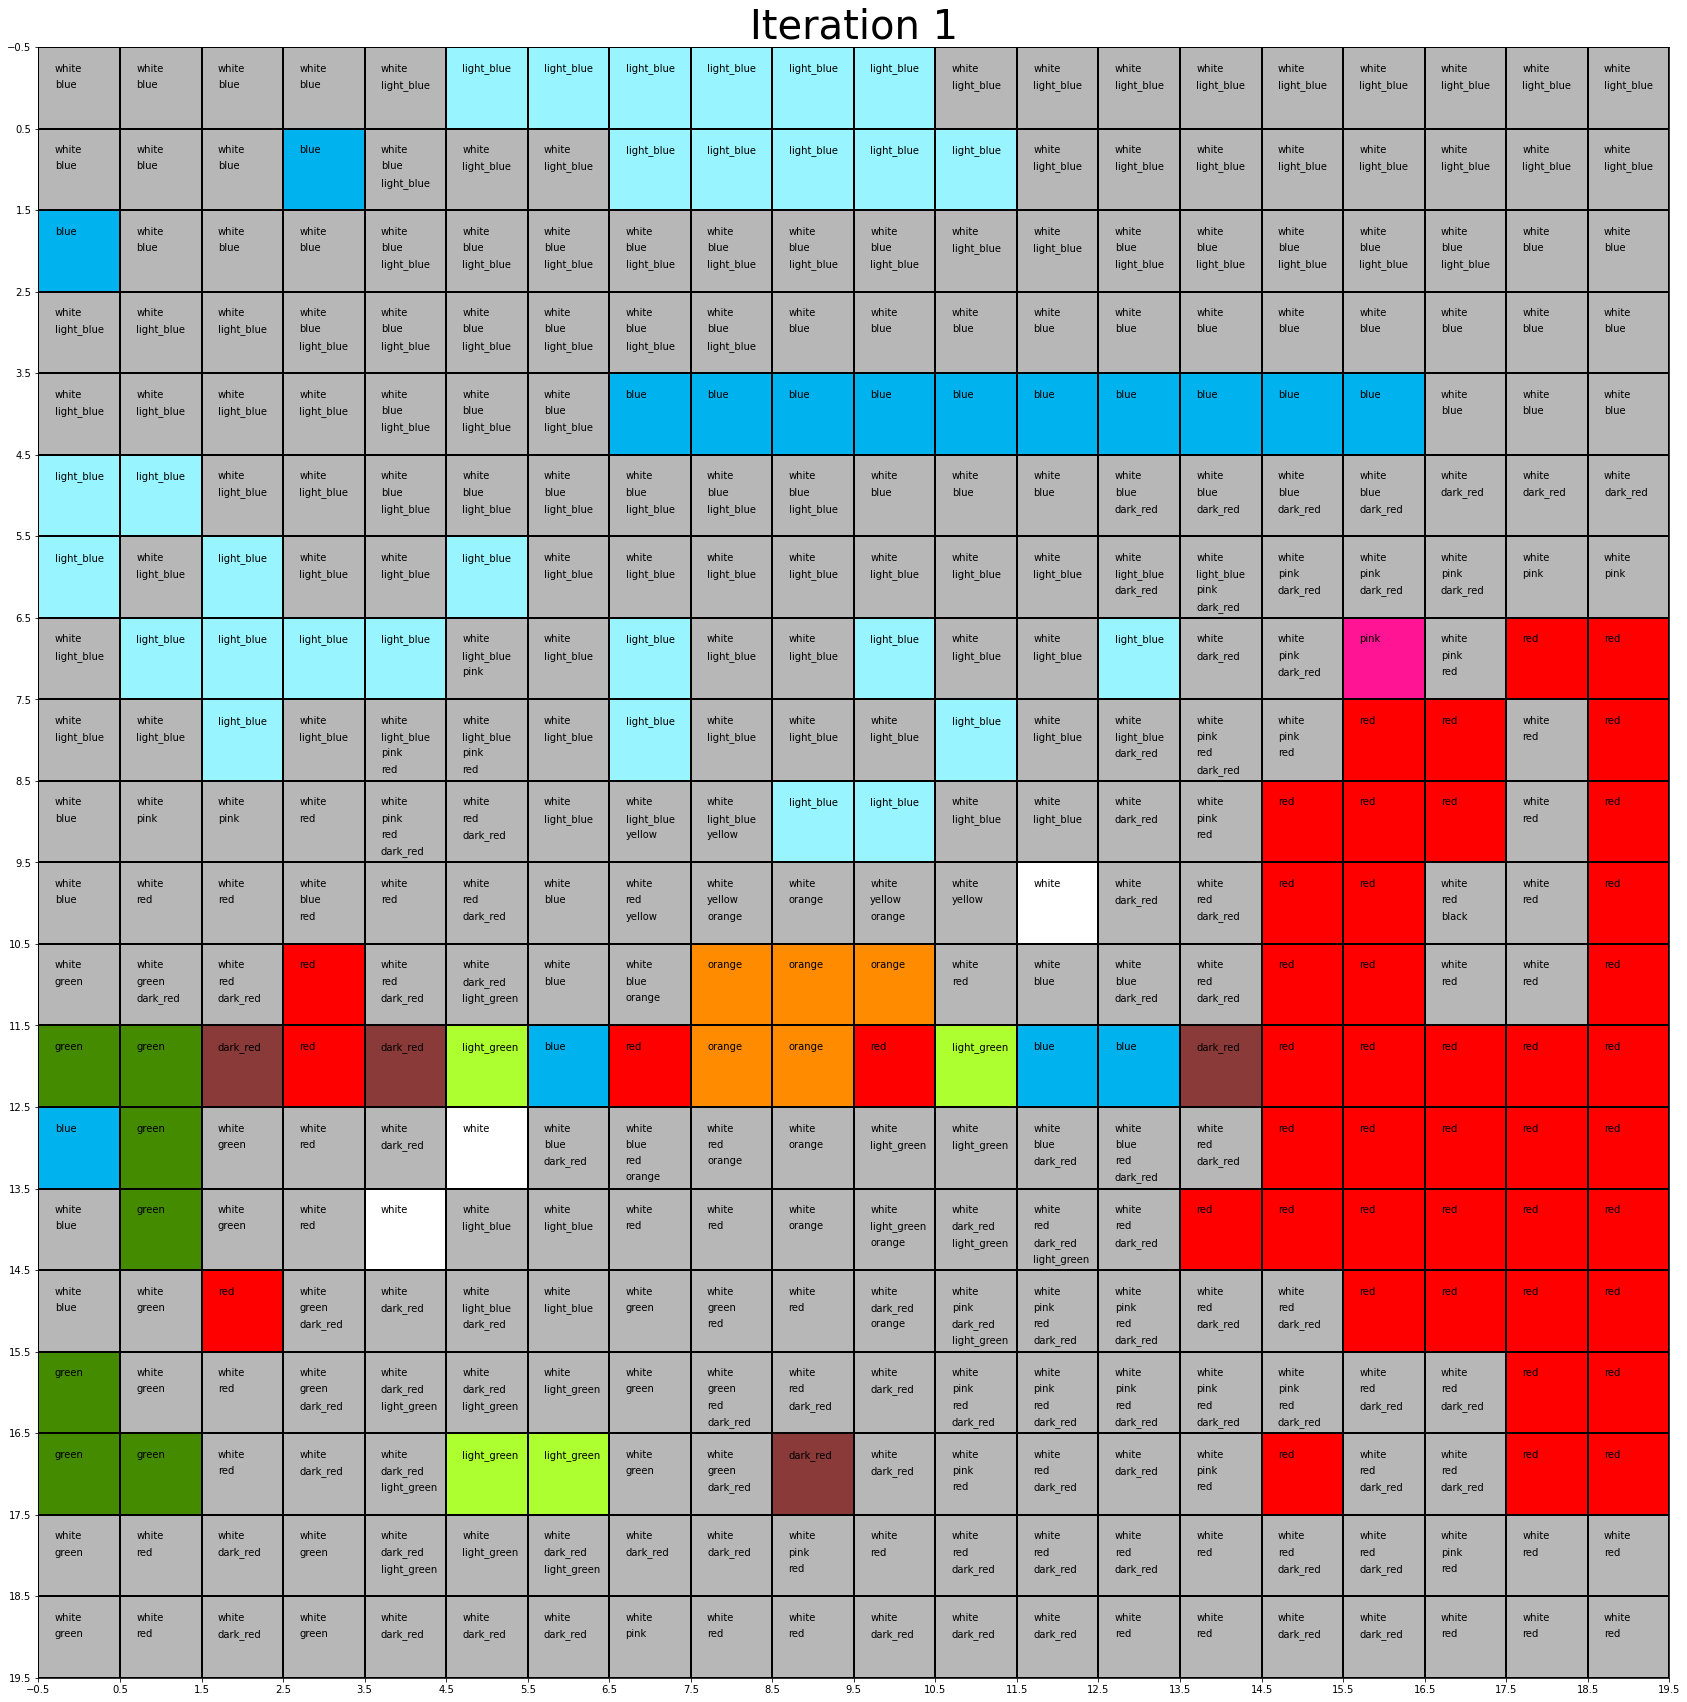

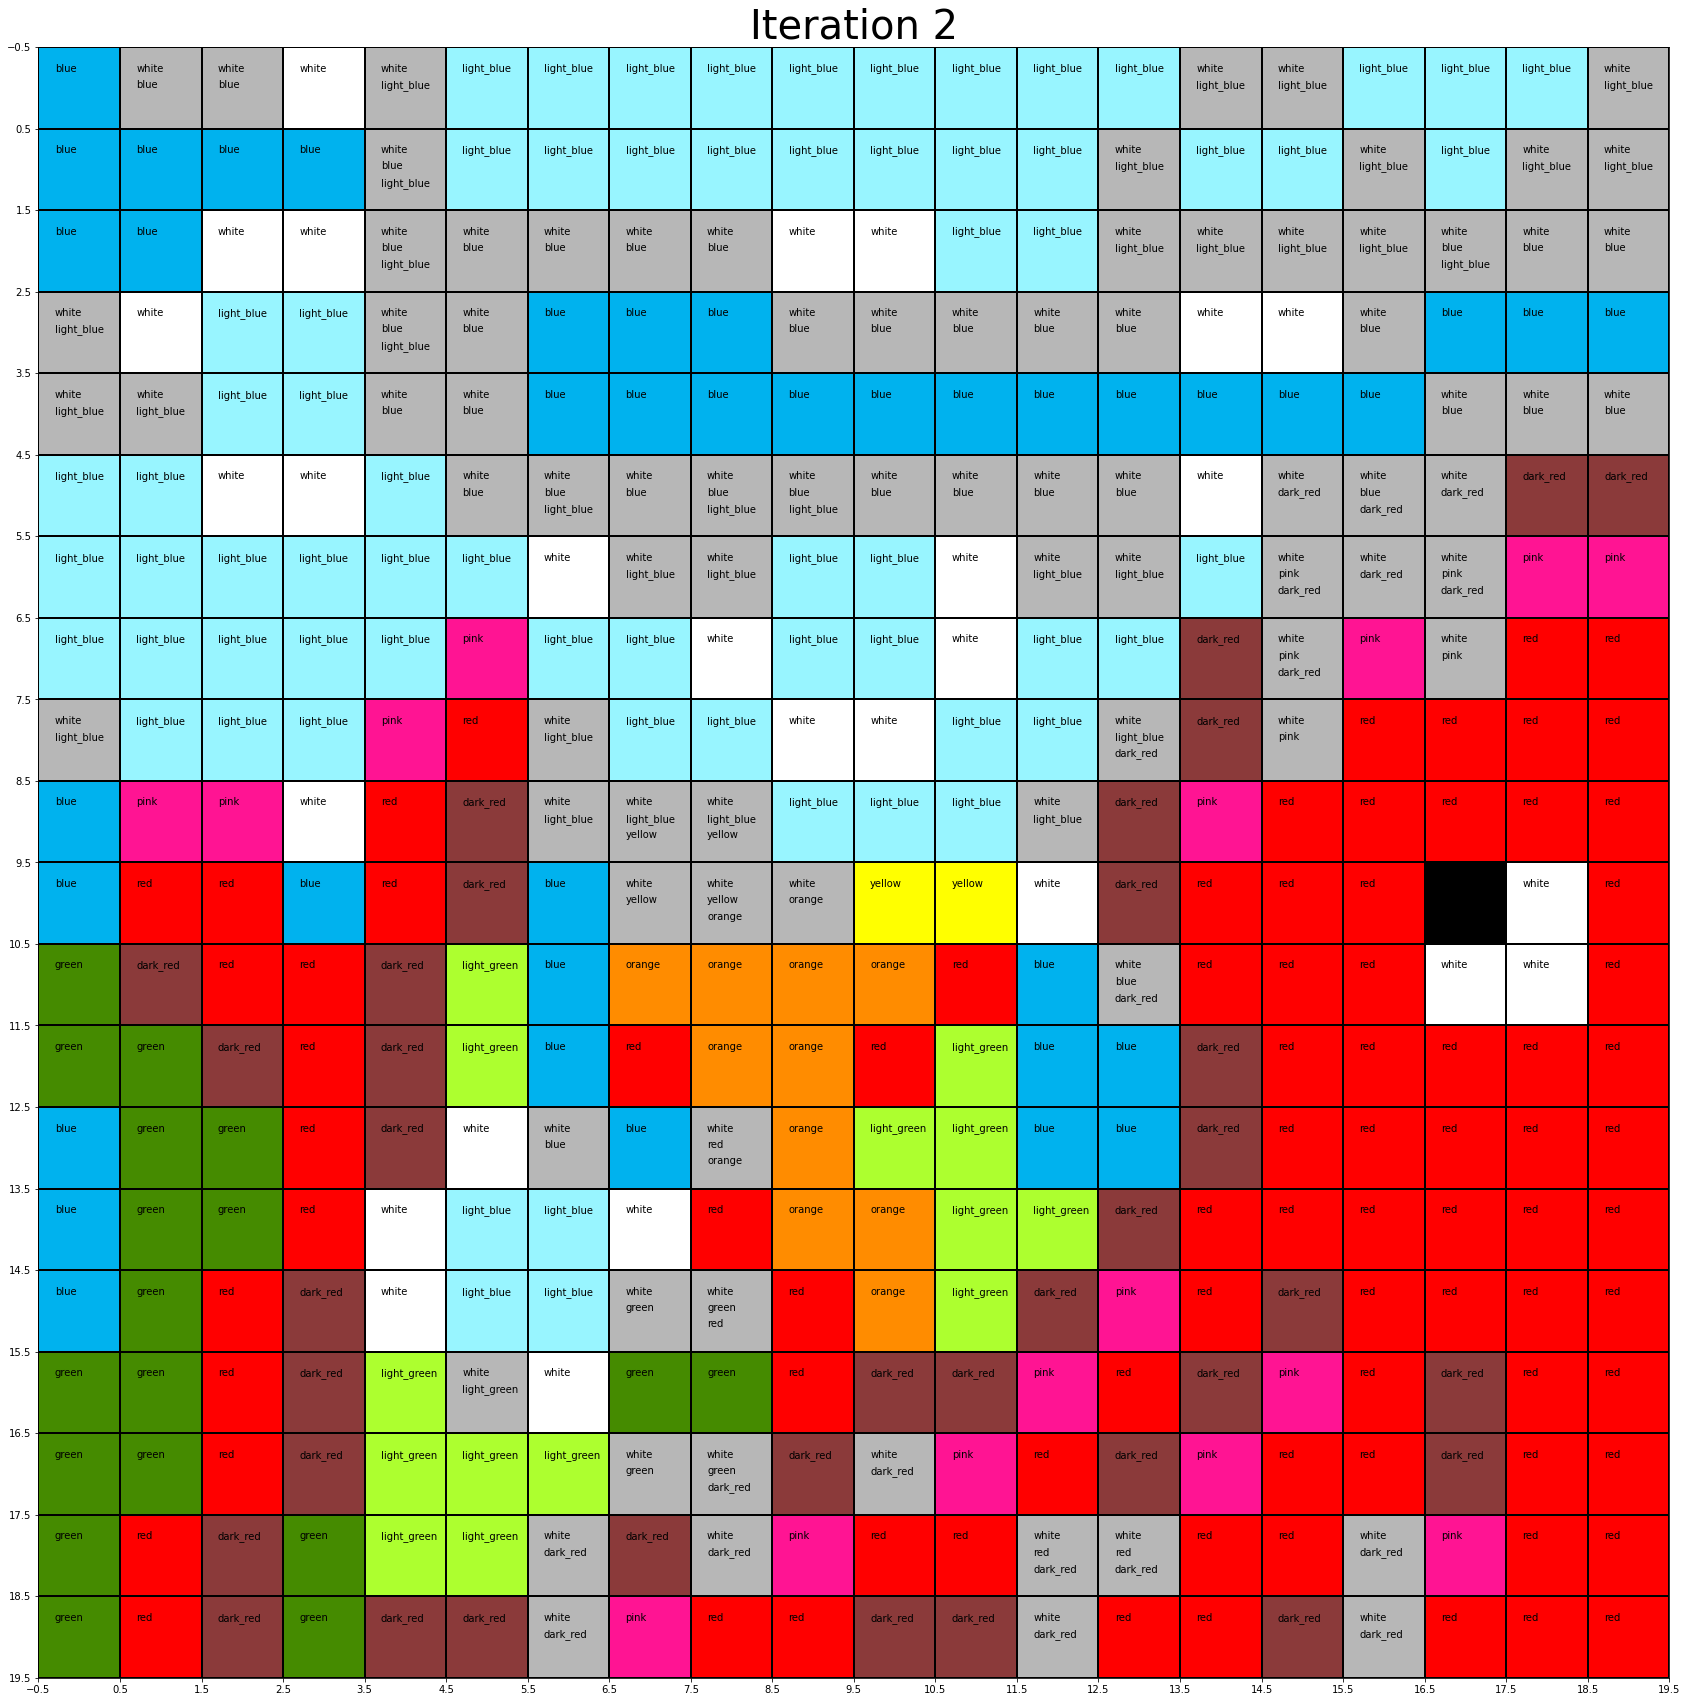

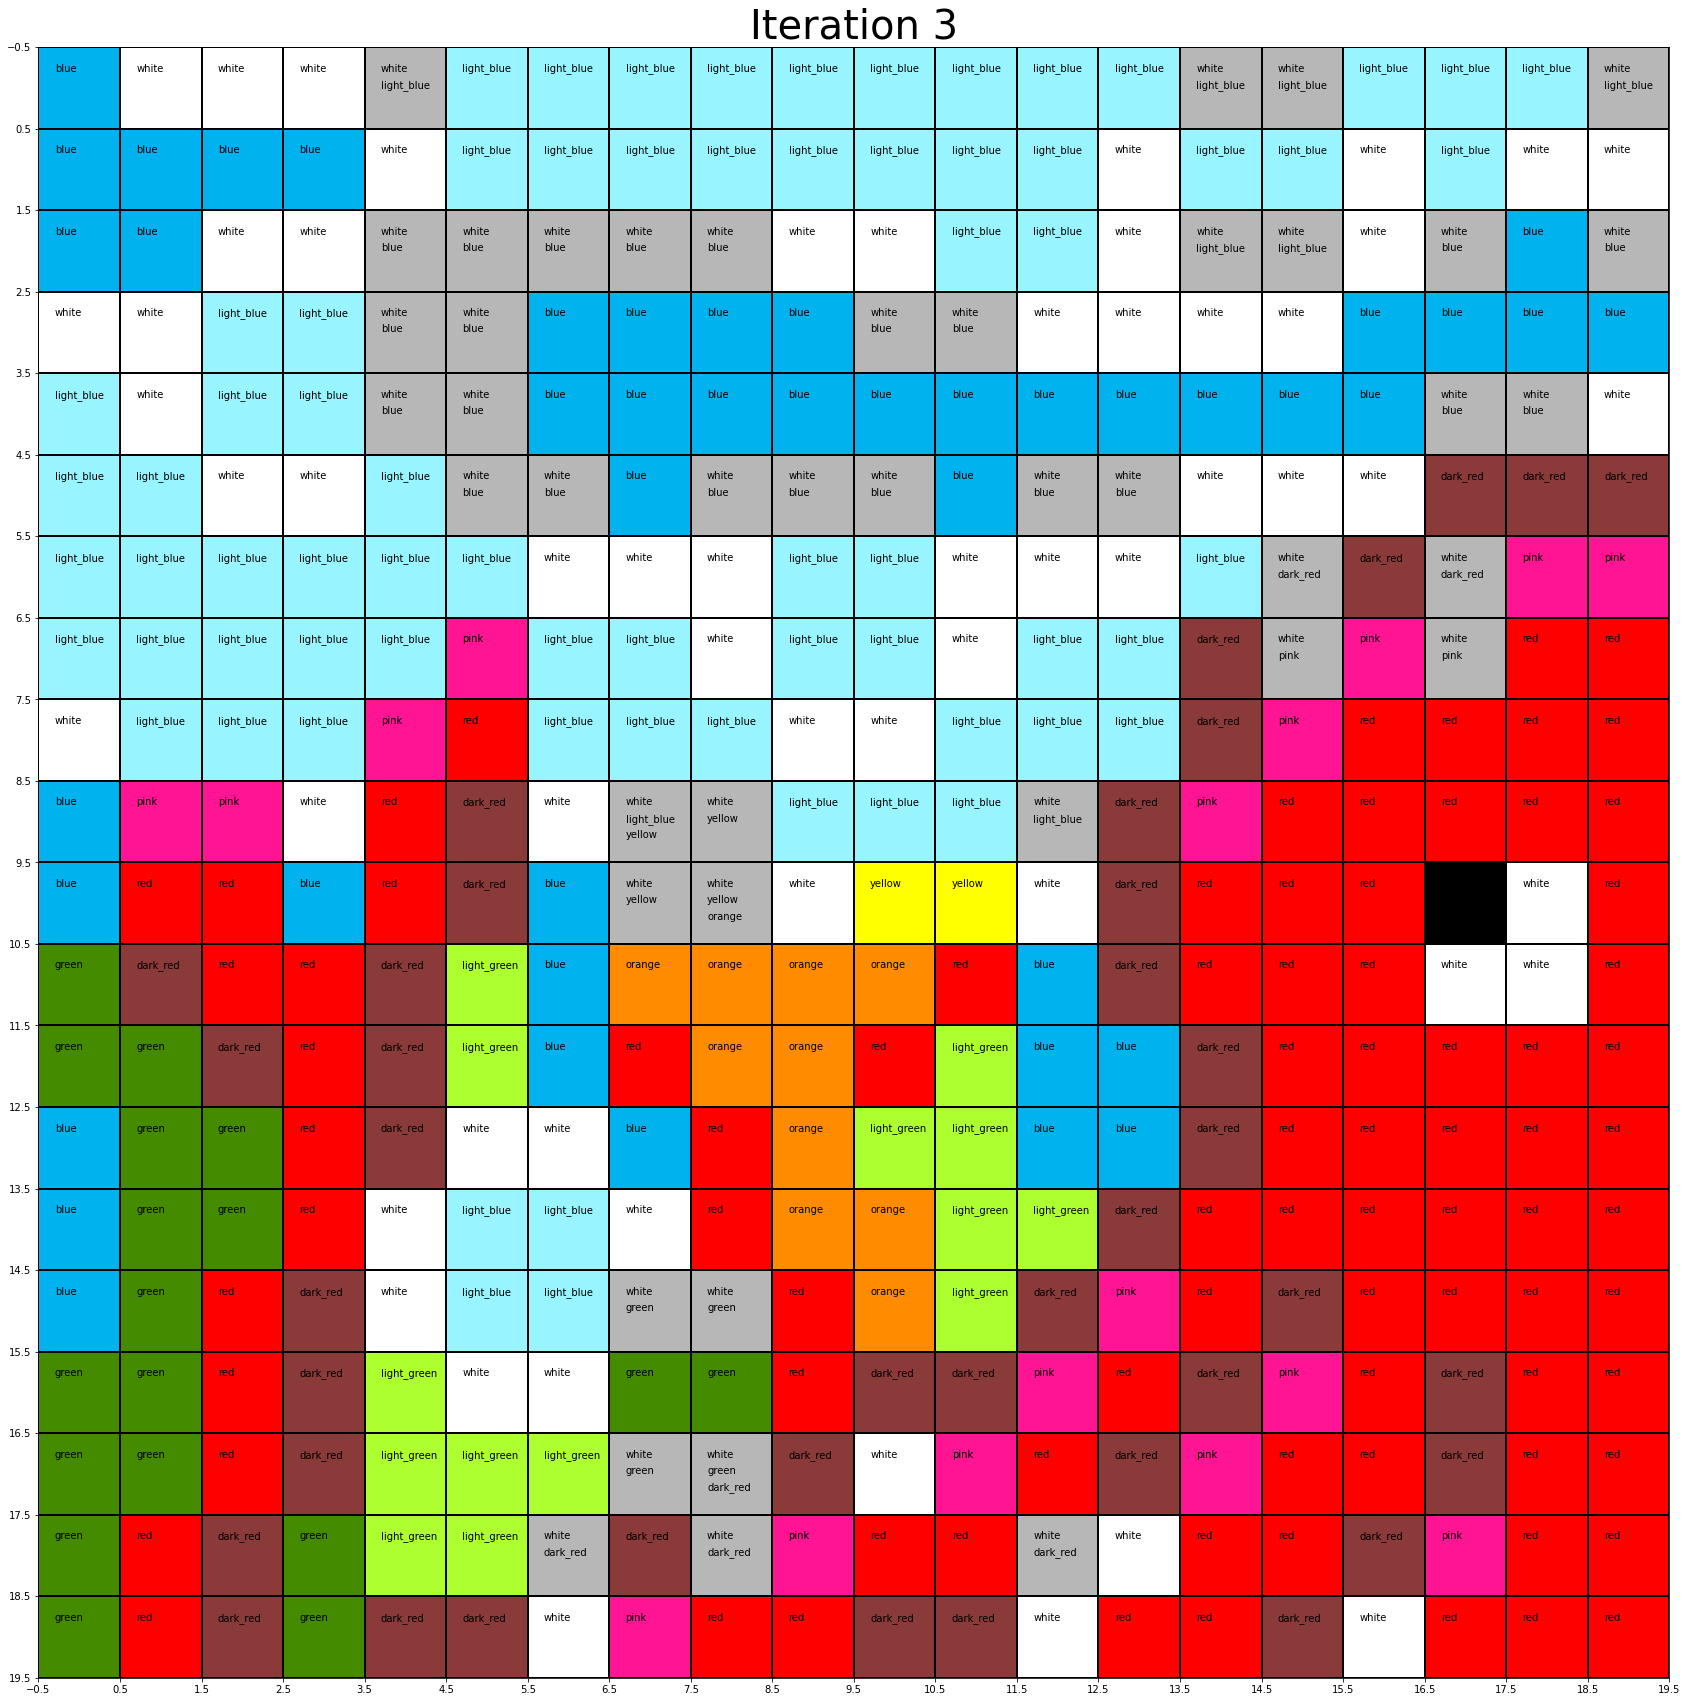

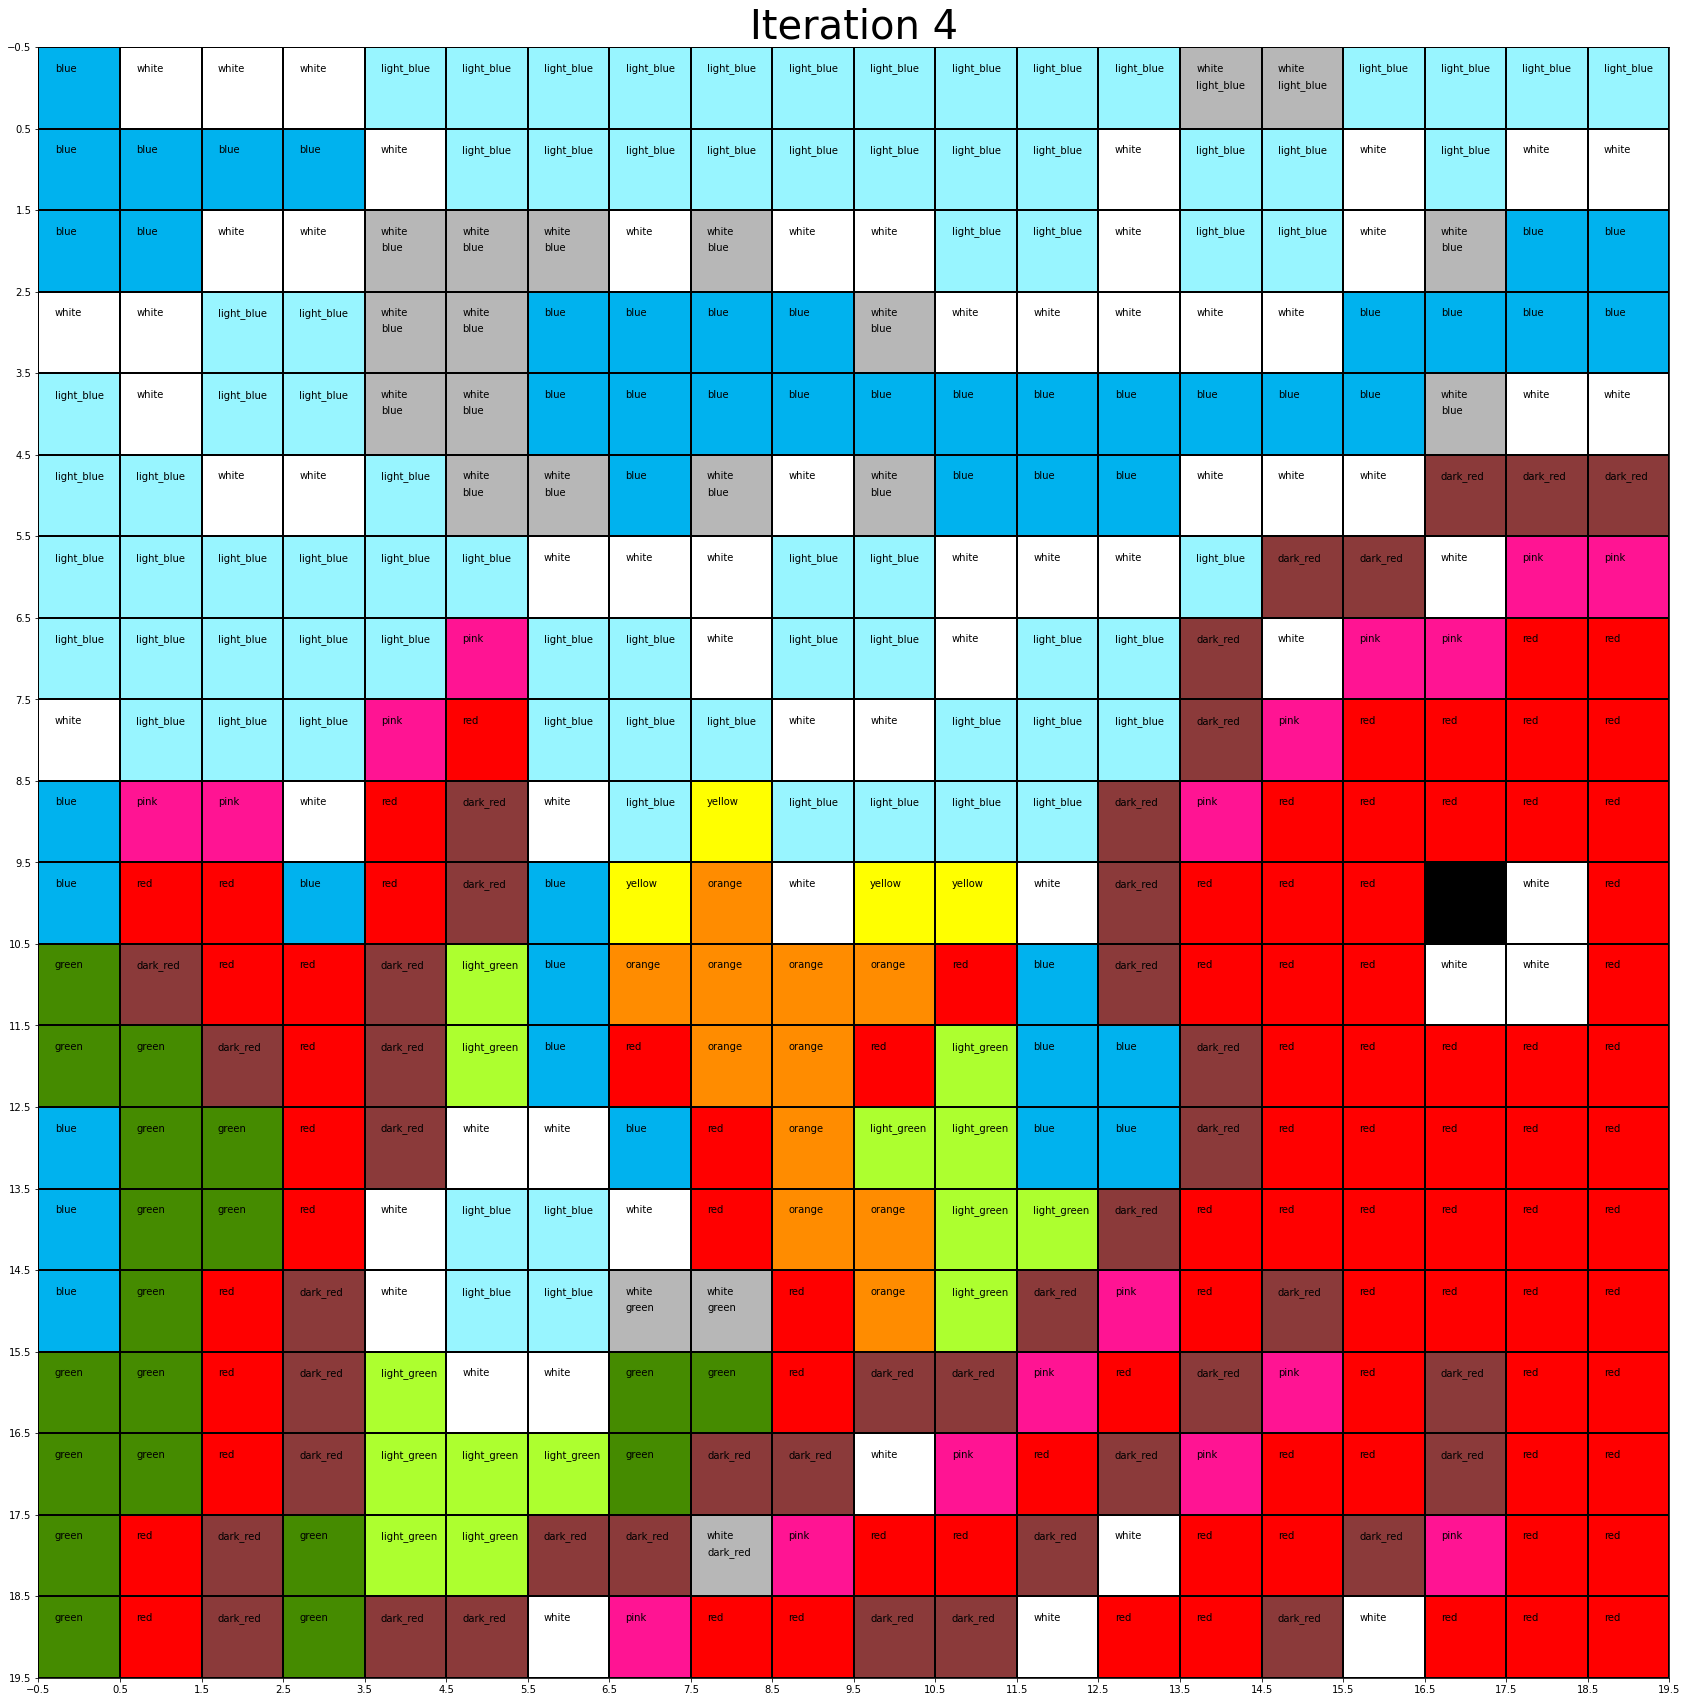

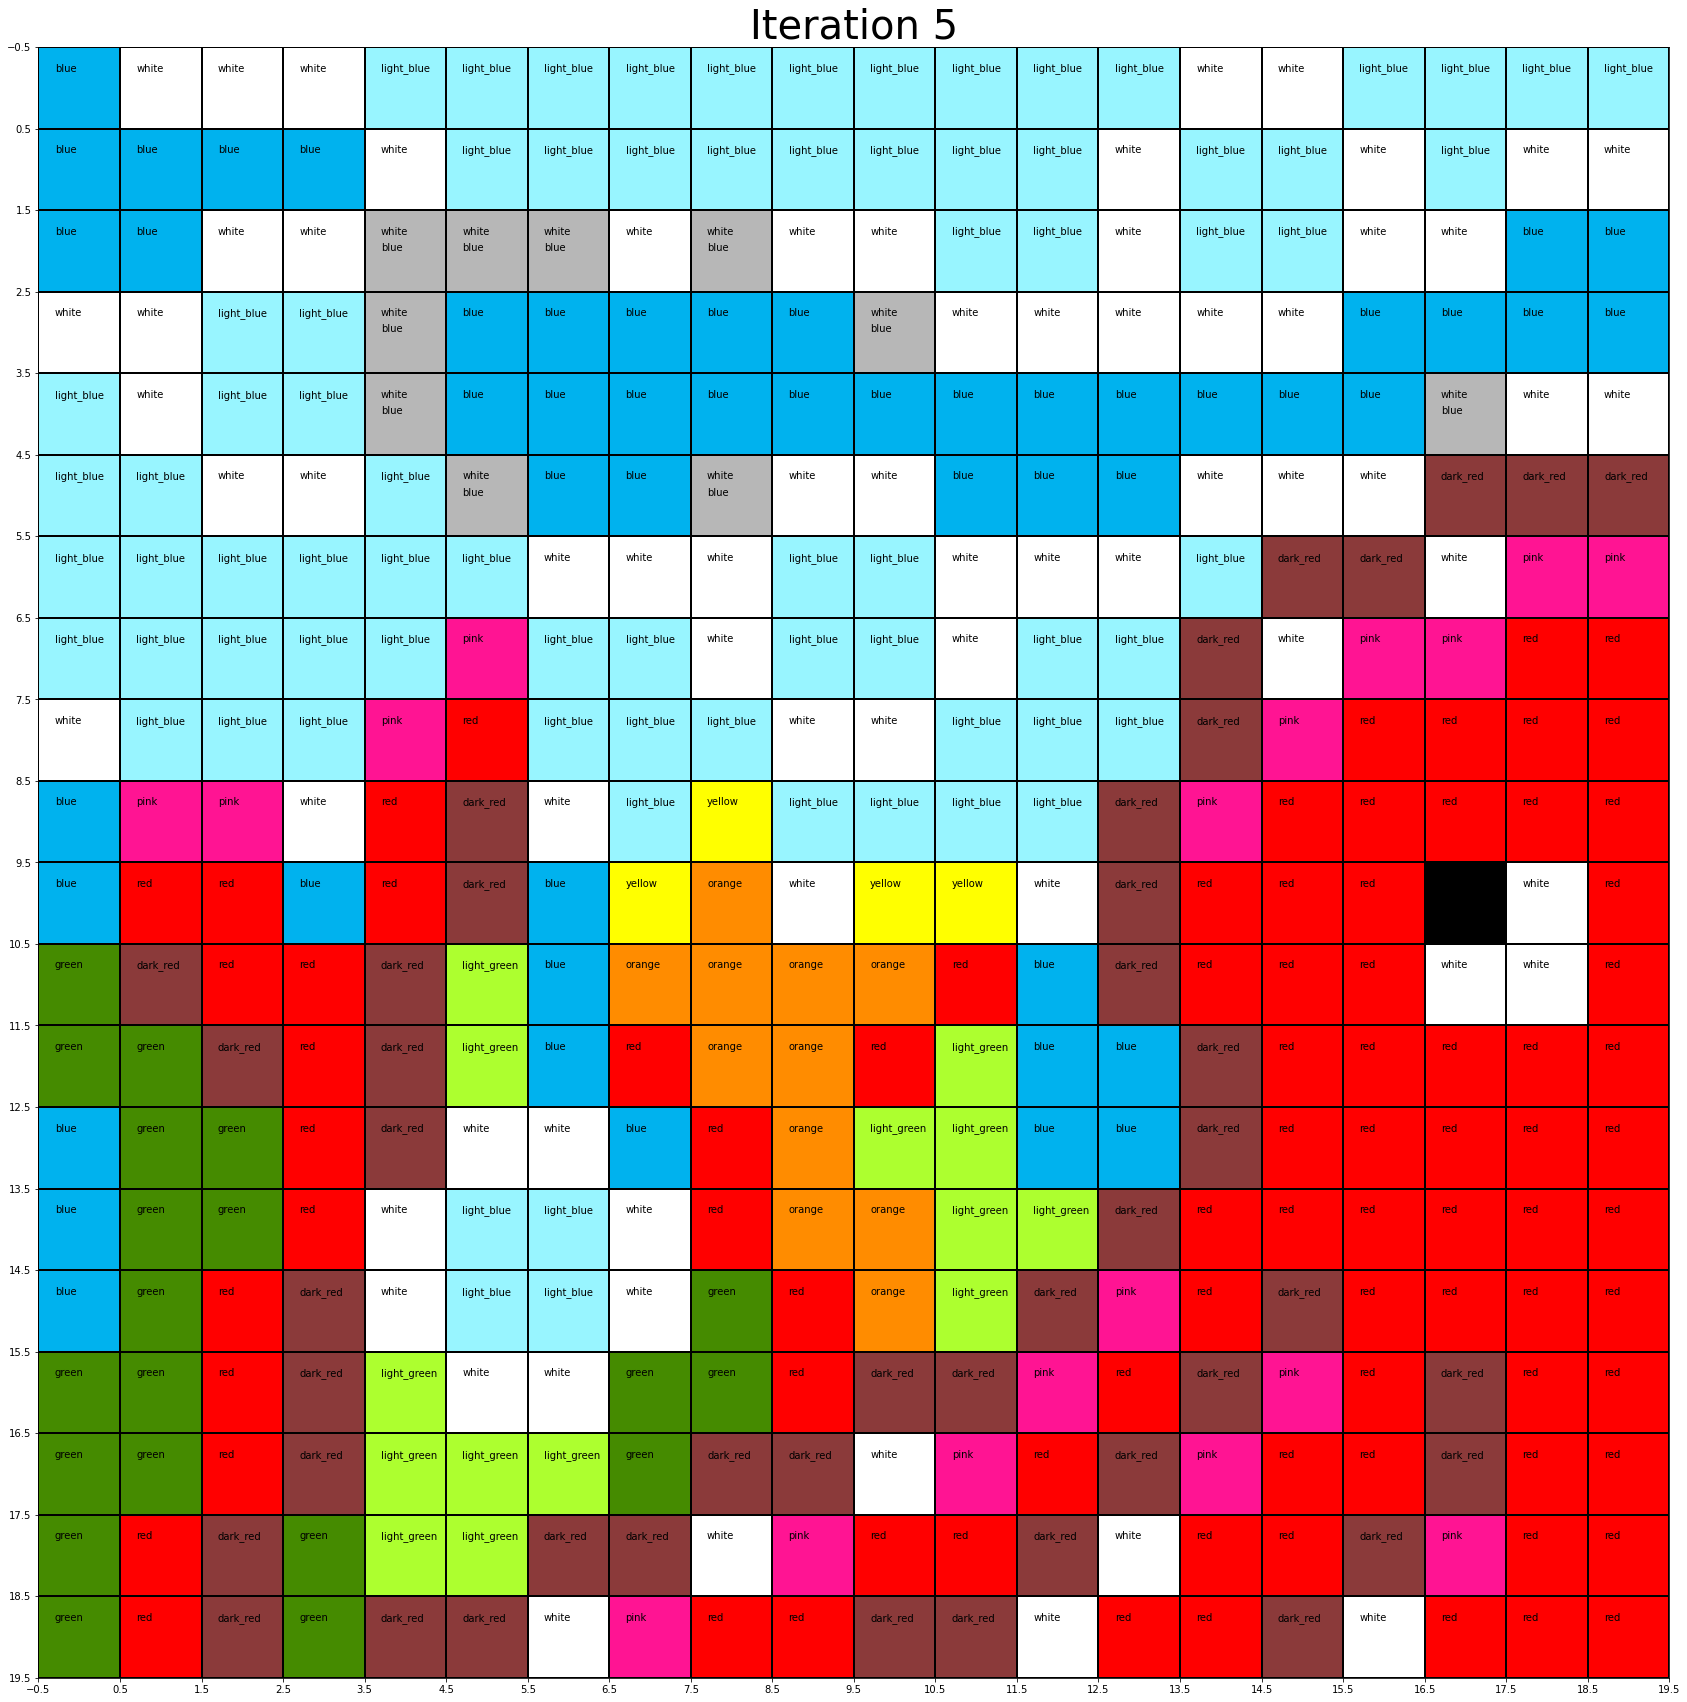

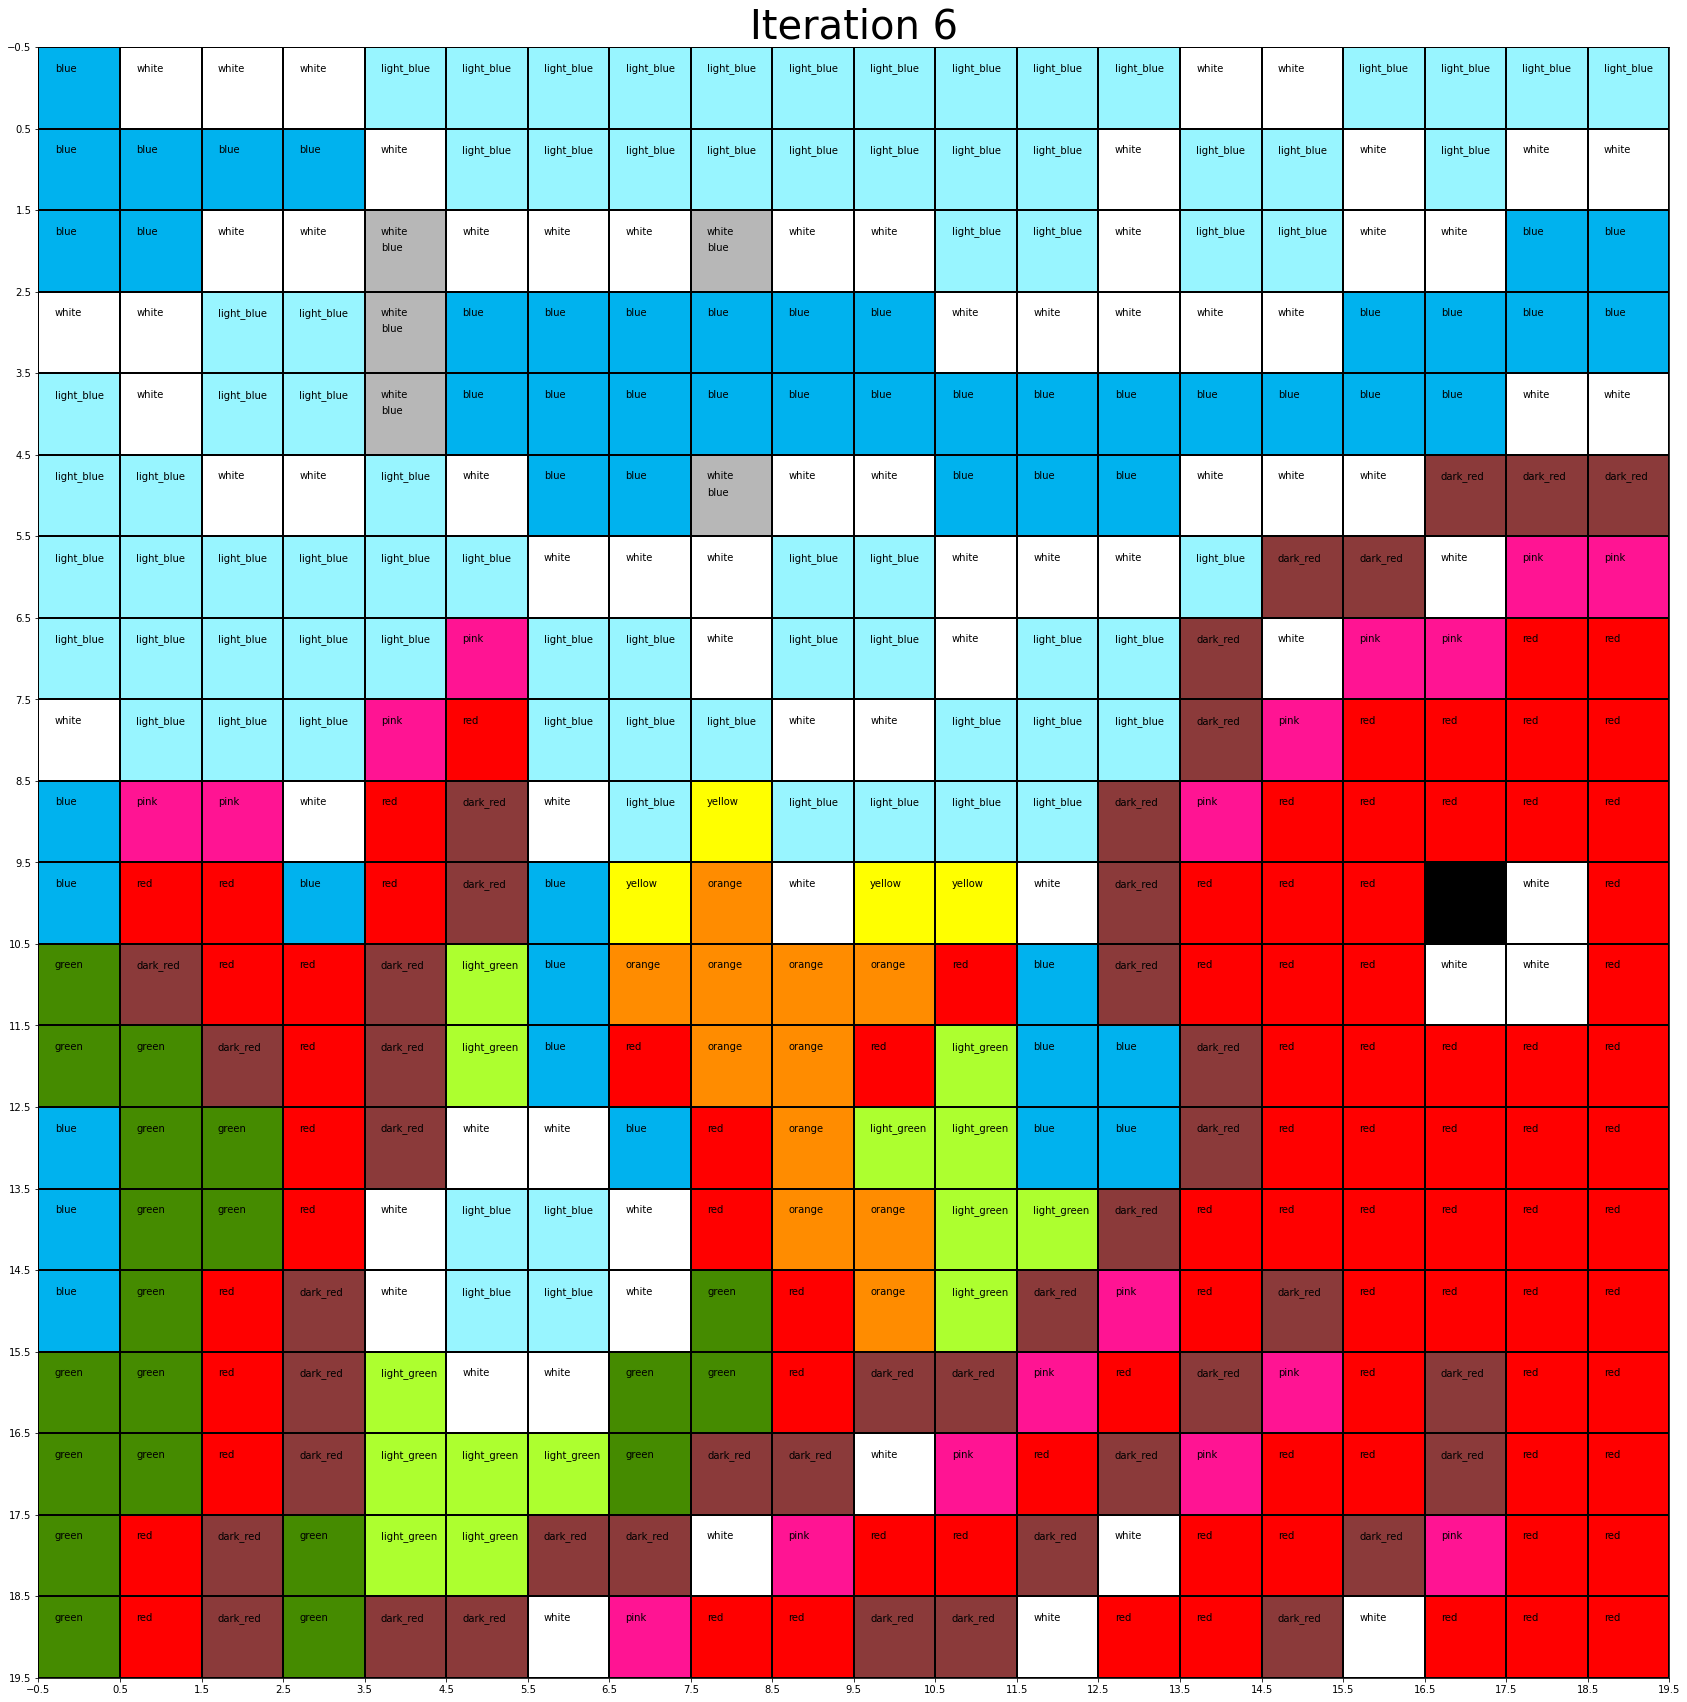

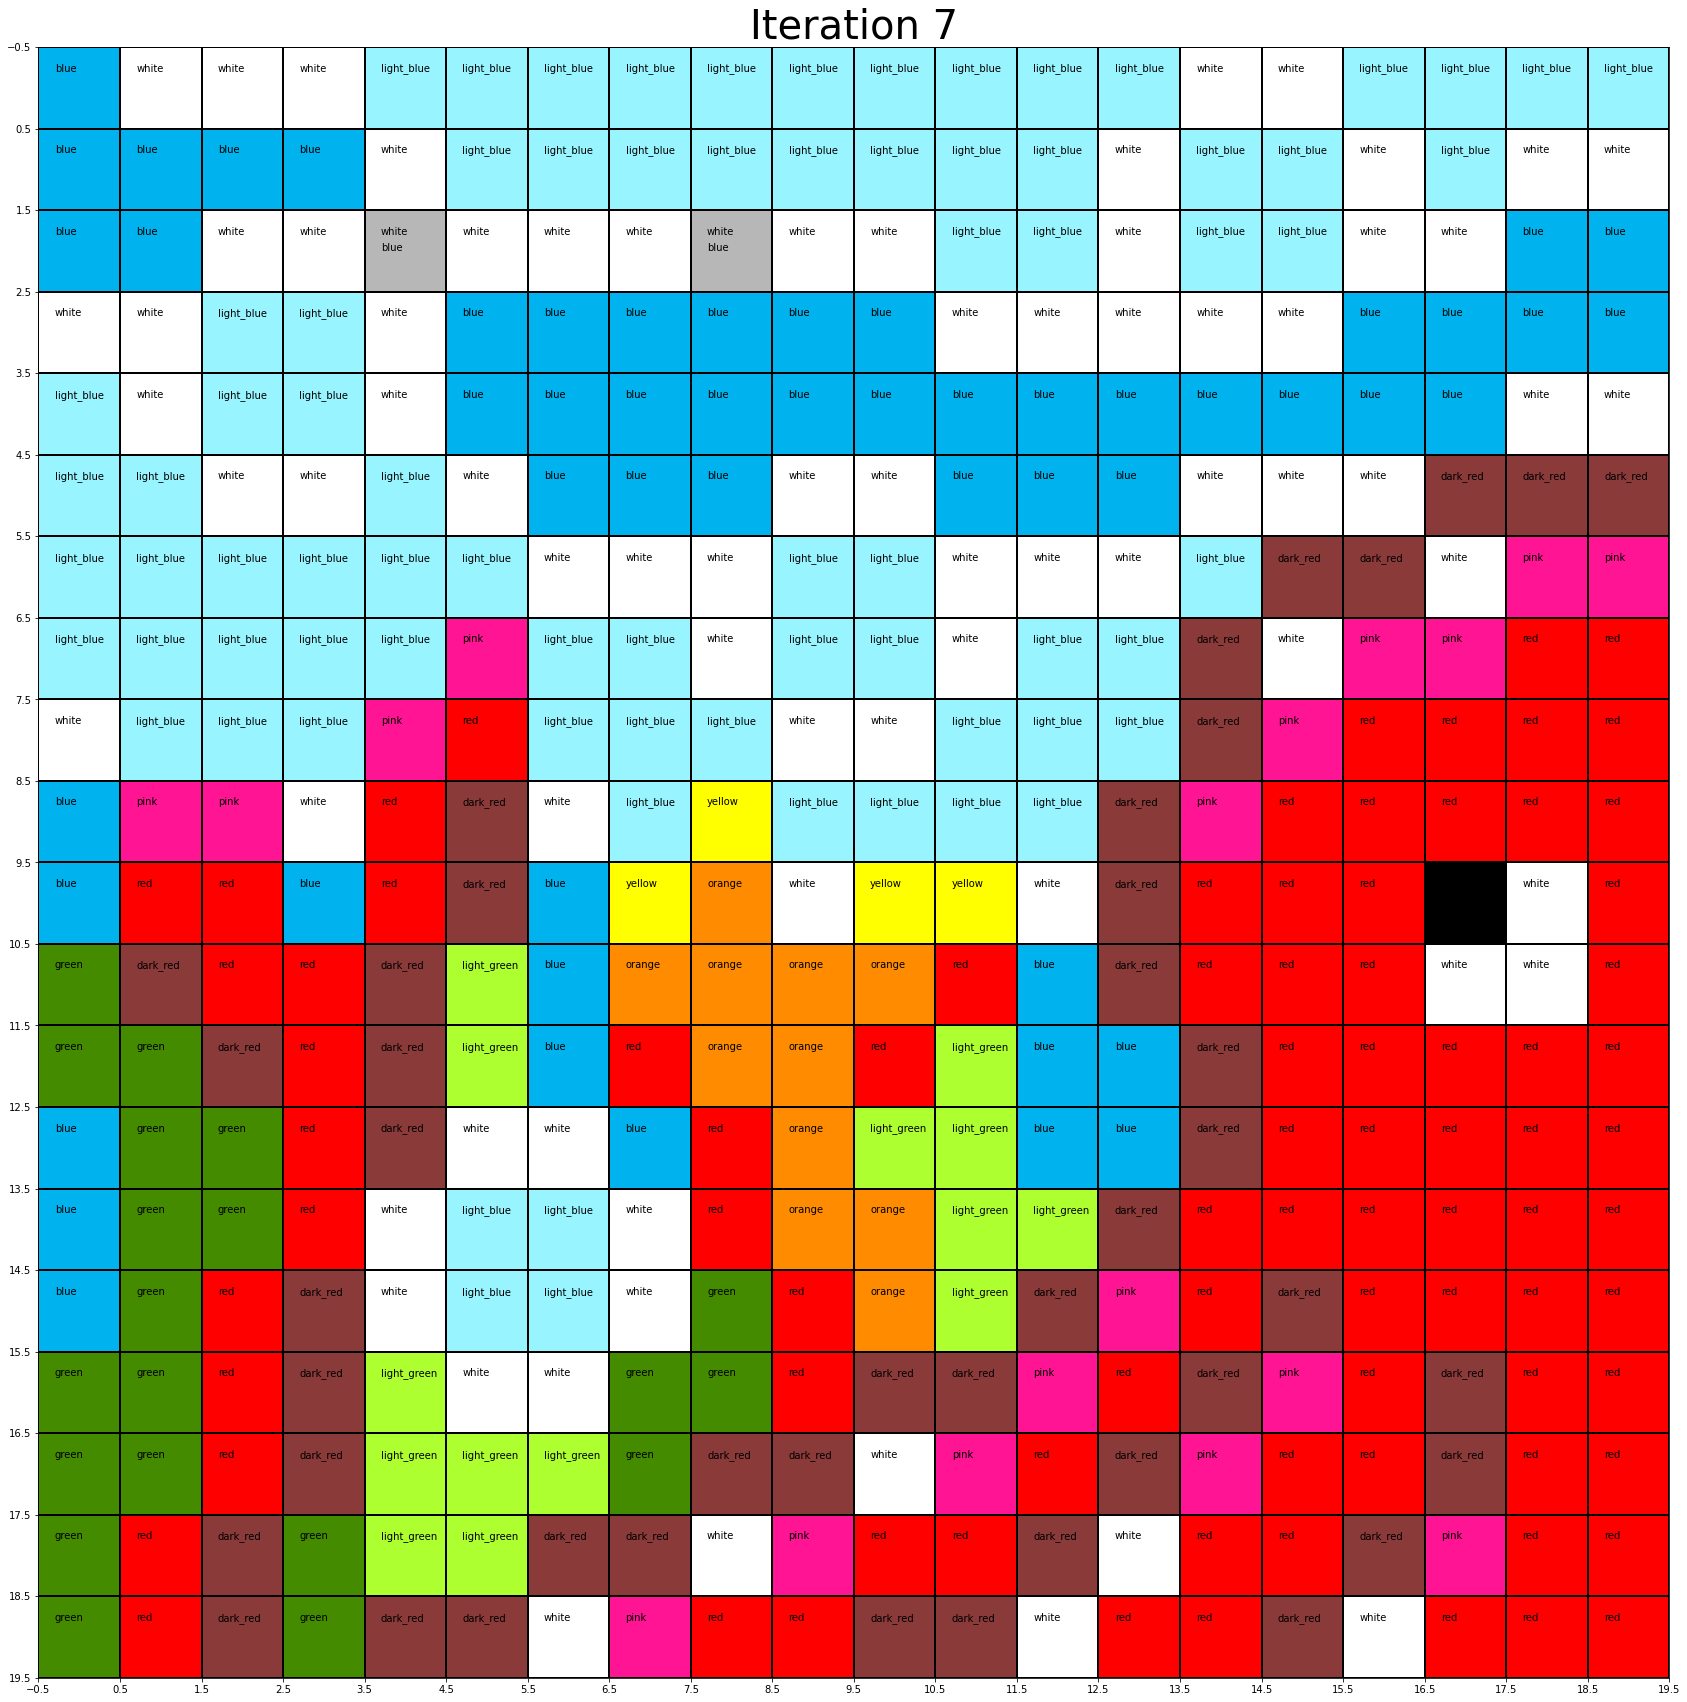

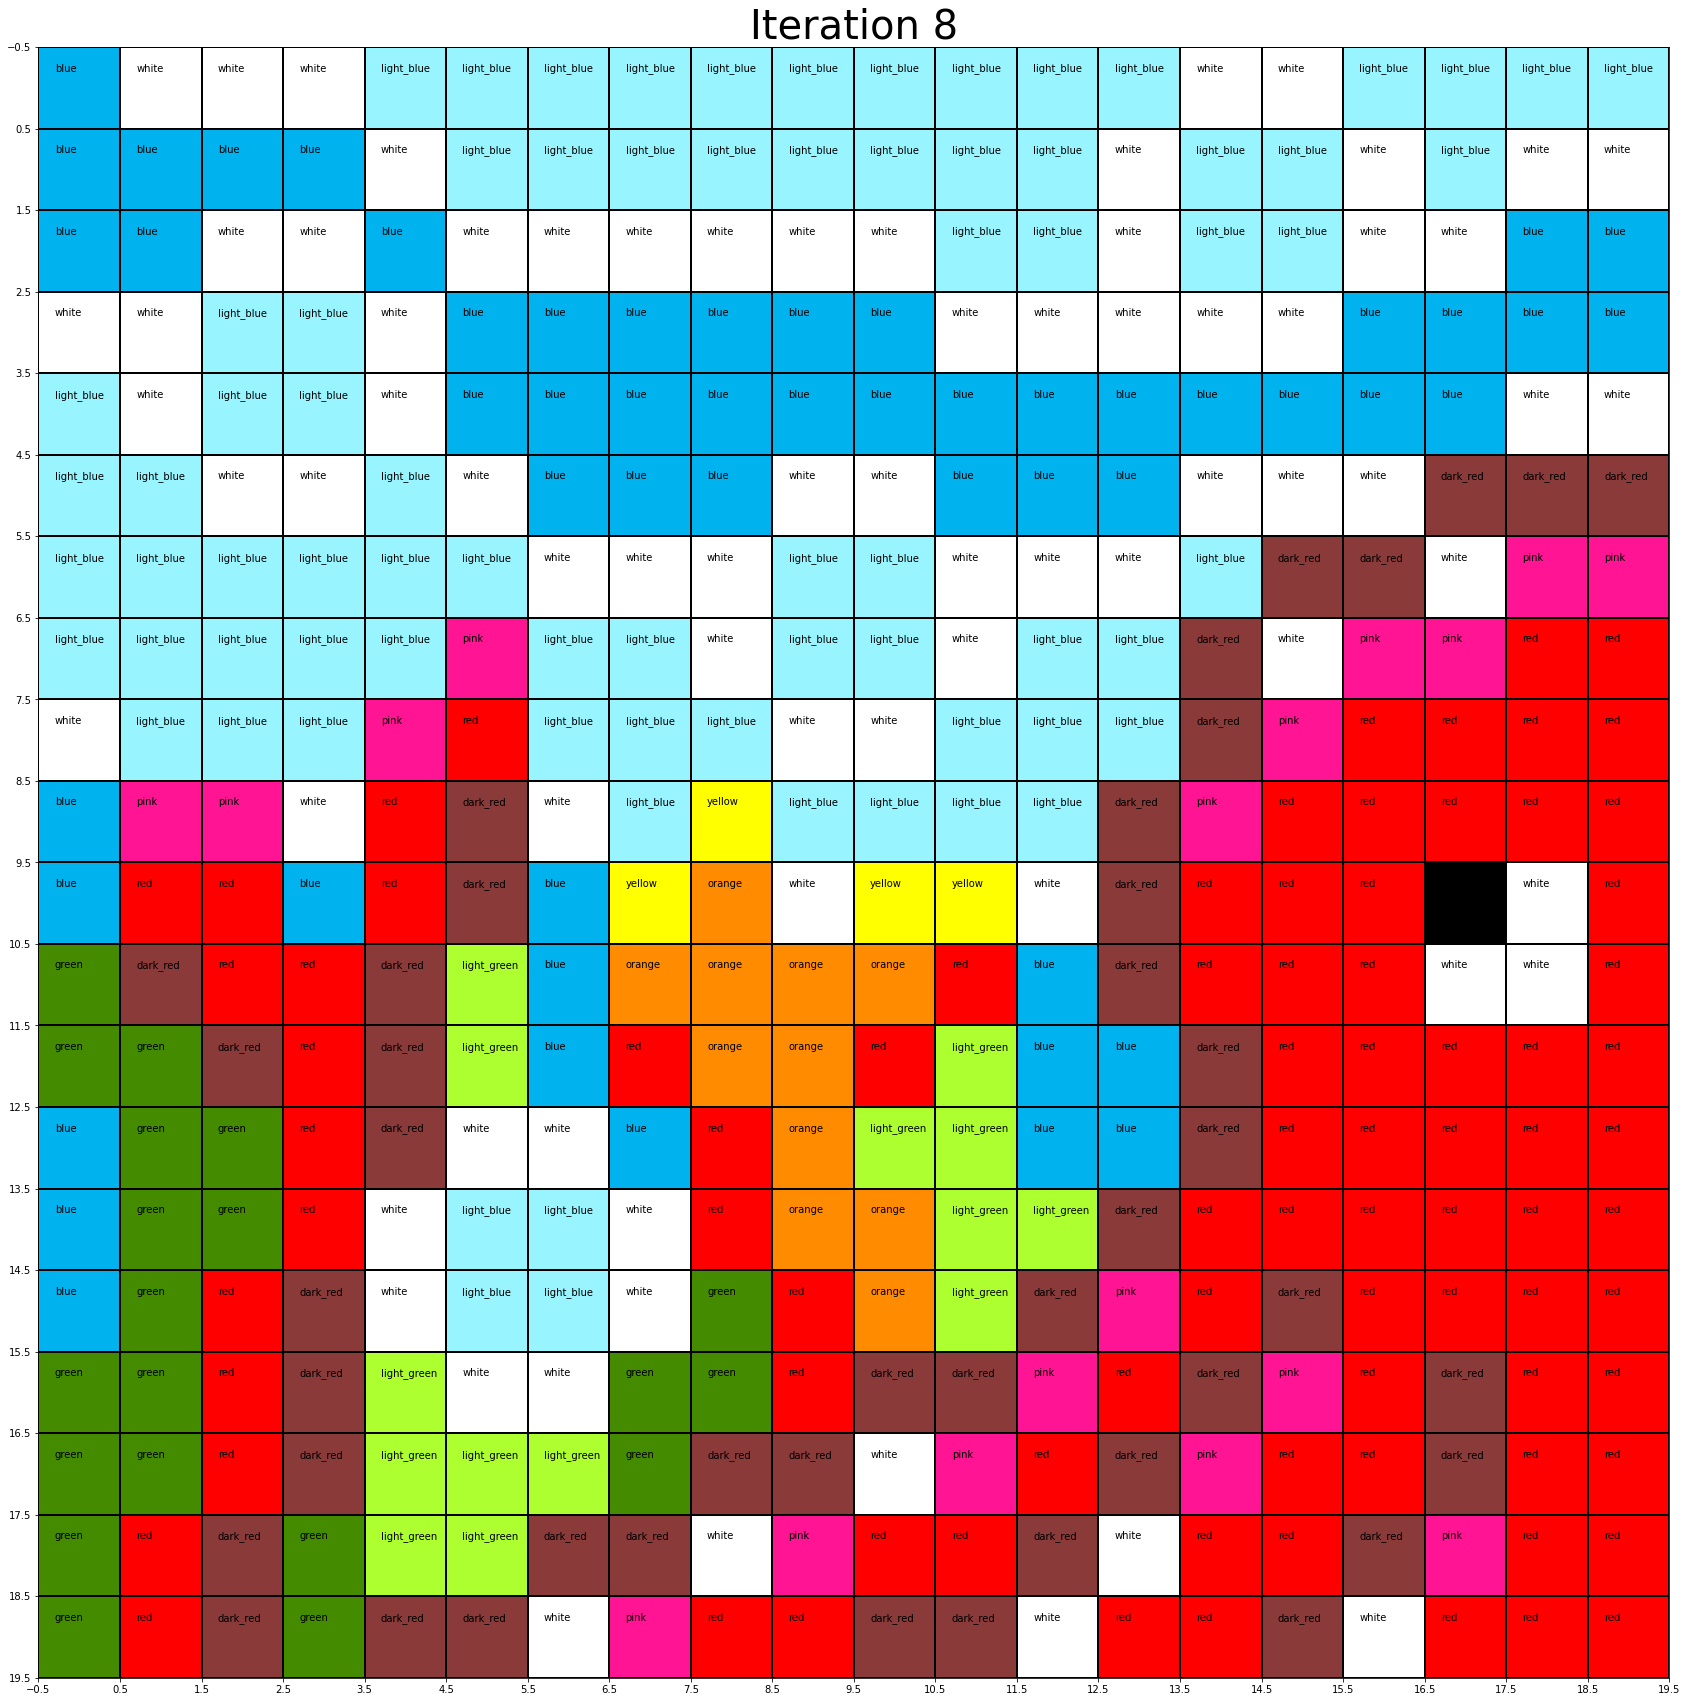

In [10]:
#Run the algorithm
solved, messages_last = updated_nonogram_solver(messages_up, messages_rows_down, messages_columns_down, row_configs, col_configs)

#Filter the solutions if guesses have been made
if(len(all_solutions)>1):
    filtered_solutions = []
    for solution in all_solutions:
        if not any([(solution == solution_).all() for solution_ in filtered_solutions]):
            filtered_solutions.append(solution)